In [36]:
import matplotlib.pyplot as plt
import tensorflow as tf

from iexfinance.stocks import Stock
from iexfinance.stocks import get_historical_data
from iexfinance.stocks import get_historical_intraday
from datetime import datetime
import pandas as pd

In [37]:
#create stock object based on ticker
goos = Stock('GOOS')

#data range
start = datetime(2017,3,17)
end = datetime(2019,1,25)

#pull historical data for ticker
goos_data = get_historical_data("GOOS", start, end, output_format='pandas')
goos_data.head()

,open,high,low,close,volume
date,,,,,
2017-03-17,16.59,17.69,16.54,17.23,9366957
2017-03-20,17.10,17.20,16.55,17.10,2252963
2017-03-21,17.07,17.32,16.50,16.52,1785613
2017-03-22,16.47,16.53,16.00,16.05,1047949
2017-03-23,16.07,16.25,15.75,15.96,1256039


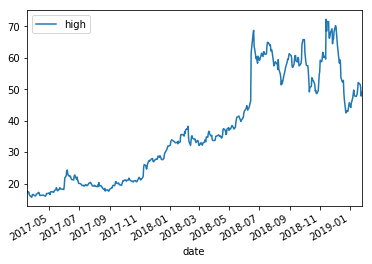

In [38]:
#plot
goos_data.plot(y='high')

In [39]:
day = datetime(2019,1,25)
goos_daily = get_historical_intraday("GOOS", day, output_format='pandas')
goos_daily.head()

,average,changeOverTime,close,date,high,label,low,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume,notional,numberOfTrades,open,volume
minute,,,,,,,,,,,,,,,,,,,,
09:30,-1.000,NaN,NaN,20190125,-1.00,09:30 AM,-1.000,47.038,0.000000,47.170,47.18,46.950,1.347957e+06,81,46.960,28657,0.0,0,NaN,0
09:31,47.122,-48.122,47.085,20190125,47.14,09:31 AM,47.085,47.126,0.001871,47.055,47.25,47.000,1.170946e+06,121,47.138,24847,28273.0,2,47.14,600
09:32,47.192,-48.192,47.250,20190125,47.25,09:32 AM,47.100,47.165,0.002700,47.290,47.30,47.030,8.229751e+05,109,47.090,17449,42473.0,5,47.10,900
09:33,-1.000,NaN,NaN,20190125,-1.00,09:33 AM,-1.000,47.371,0.007079,47.479,47.48,47.218,6.092438e+05,100,47.290,12861,0.0,0,NaN,0
09:34,47.293,-48.293,47.220,20190125,47.38,09:34 AM,47.220,47.323,0.006059,47.250,47.48,47.150,7.812974e+05,128,47.475,16510,14188.0,3,47.38,300


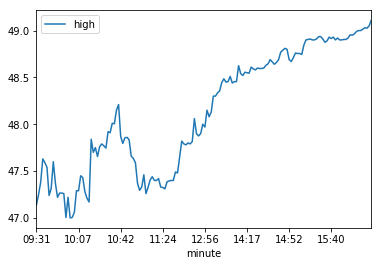

In [40]:
#drop null sets
goos_daily.dropna(inplace = True)

#plot
goos_daily.plot(y='high')

In [102]:
#Long Short Term Memory Test
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import numpy as np

In [103]:
#creating dataframe
stock = Stock('GOOS')
start = datetime(2017,3,17)
end = datetime(2019,1,25)
stock_data = get_historical_data("GOOS", start, end, output_format='pandas')
stock_data.reset_index(inplace=True)
new_data = pd.DataFrame(index=range(0,len(stock_data)),columns=['date', 'close'])
for i in range(0,len(stock_data)):
    new_data['date'][i] = stock_data['date'][i]
    new_data['close'][i] = stock_data['close'][i]

In [104]:
#setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:300,:]
valid = dataset[300:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


/home/abel/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [105]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 22s - loss: 0.0045


In [106]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [107]:
#results
rms = np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

6.481014831976492

/home/abel/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/abel/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


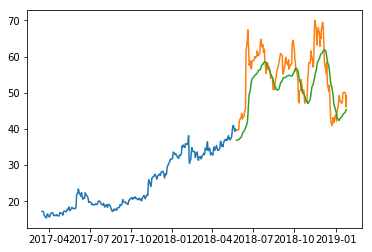

In [108]:
#plotting
train = new_data[:300]
valid = new_data[300:]
valid['prediction'] = 0.0
valid['predictions'] = closing_price
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])

In [114]:
valid['predictions'].tail()

date
2019-01-18    44.167324
2019-01-22    44.506844
2019-01-23    44.863445
2019-01-24    45.193829
2019-01-25    45.317173
Name: predictions, dtype: float32

In [115]:
stock_data.tail()

,date,open,high,low,close,volume
463,2019-01-18,50.47,52.1800,49.87,50.08,2572498
464,2019-01-22,49.41,51.5400,49.18,50.05,2033101
465,2019-01-23,50.08,50.7300,48.79,49.65,1761791
466,2019-01-24,47.77,47.8500,44.16,46.05,7666863
467,2019-01-25,46.96,49.1121,46.81,49.11,3062178
